IT Support Ticket Classification and Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# wordcloud
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import RegexpTokenizer

from flask import Flask, render_template, request

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abhinavdeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read dataset
path = "./Datasets/cat-tickets.csv"
tickets = pd.read_csv(path)

Exploratory Data Analysis

In [3]:
# describing data
tickets.describe()

,Description,Category
count,3000,3000
unique,3000,5
top,hi since recruiter lead permission approve req...,D
freq,1,600


In [4]:
# how data looks
tickets.head()

,Description,Category
0,hi since recruiter lead permission approve req...,D
1,re expire days hi ask help update passwords co...,D
2,verification warning hi has got attached pleas...,D
3,please dear looks blacklisted receiving mails ...,D
4,dear modules report report cost thank much reg...,D


In [5]:
tickets.shape

(3000, 2)

In [6]:
# value count of each category
tickets['Category'].value_counts()

D    600
E    600
A    600
B    600
C    600
Name: Category, dtype: int64

<AxesSubplot:xlabel='Category', ylabel='count'>

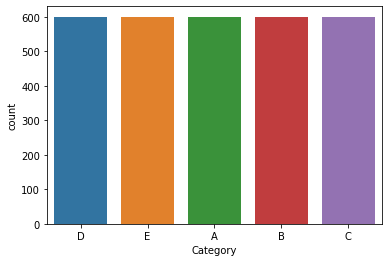

In [7]:
# # visualising data
sns.countplot(x = tickets['Category'])

In [8]:
tickets['Description']

0       hi since recruiter lead permission approve req...
1       re expire days hi ask help update passwords co...
2       verification warning hi has got attached pleas...
3       please dear looks blacklisted receiving mails ...
4       dear modules report report cost thank much reg...
                              ...                        
2995    sent tuesday feedback follow up conf call hell...
2996    sent monday issues hi keep getting errors whil...
2997    sent monday en working properly hi guys we hav...
2998    sent wednesday july hi please log incident for...
2999    sent tuesday july connection issues hello have...
Name: Description, Length: 3000, dtype: object

In [9]:
'''
cat_A = tickets[tickets["Category"] == 'A']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_A["Description"]))
plt.imshow(wc)'''

'\ncat_A = tickets[tickets["Category"] == \'A\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_A["Description"]))\nplt.imshow(wc)'

In [10]:
'''cat_B = tickets[tickets["Category"] == 'B']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_B["Description"]))
plt.imshow(wc)'''

'cat_B = tickets[tickets["Category"] == \'B\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_B["Description"]))\nplt.imshow(wc)'

In [11]:
'''cat_C = tickets[tickets["Category"] == 'C']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_C["Description"]))
plt.imshow(wc)'''

'cat_C = tickets[tickets["Category"] == \'C\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_C["Description"]))\nplt.imshow(wc)'

In [12]:
'''cat_D = tickets[tickets["Category"] == 'D']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_D["Description"]))
plt.imshow(wc)'''

'cat_D = tickets[tickets["Category"] == \'D\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_D["Description"]))\nplt.imshow(wc)'

In [13]:
'''cat_E = tickets[tickets["Category"] == 'E']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_E["Description"]))
plt.imshow(wc)'''

'cat_E = tickets[tickets["Category"] == \'E\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_E["Description"]))\nplt.imshow(wc)'

In [14]:
def lowwering(tickets):
    tickets['Description']=tickets['Description'].str.lower()
    tickets['Description'].head()
    return tickets
tickets = lowwering(tickets)
tickets.head()

,Description,Category
0,hi since recruiter lead permission approve req...,D
1,re expire days hi ask help update passwords co...,D
2,verification warning hi has got attached pleas...,D
3,please dear looks blacklisted receiving mails ...,D
4,dear modules report report cost thank much reg...,D


In [15]:
# defining stopwords
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'please', 'thank', 'thanks', 'card', 'hello', 'regards', 'hi', 'sent', 'dear', 'since', 'monday' , 'tuesday', 'wednessday', 'thursday', 'friday', 'saturday', 'sunday']
STOPWORDS = set(stopwordlist)
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'by',
 'can',
 'card',
 'd',
 'dear',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'few',
 'for',
 'friday',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'hello',
 'her',
 'here',
 'hers',
 'herself',
 'hi',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'monday',
 'more',
 'most',
 'my',
 'myself',
 'now',
 'o',
 'of',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'own',
 'please',
 're',
 'regards',
 's',
 'same',
 'saturday',
 'sent',
 'she',
 'shes',
 'should',
 'shouldve',
 'since',
 'so',
 'some',
 'such',
 'sunday',
 't',
 'than',
 'thank',
 'thanks',
 'that',
 'thatll',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'th

In [16]:
# removing stopwords from data
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tickets['Description'] = tickets['Description'].apply(lambda text: cleaning_stopwords(text))
tickets['Description'].tail() 

2995    feedback follow conf call setup meeting one co...
2996    issues keep getting errors errors preventing s...
2997    en working properly guys issue number en locat...
2998    wednesday july log incident laptop engineer ma...
2999    july connection issues connection issues worki...
Name: Description, dtype: object

In [ ]:
cat_A = tickets[tickets["Category"] == 'A']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_A["Description"]))
plt.imshow(wc)

In [18]:
'''cat_B = tickets[tickets["Category"] == 'B']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_B["Description"]))
plt.imshow(wc)'''

'cat_B = tickets[tickets["Category"] == \'B\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_B["Description"]))\nplt.imshow(wc)'

In [19]:
'''cat_C = tickets[tickets["Category"] == 'C']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_C["Description"]))
plt.imshow(wc)'''

'cat_C = tickets[tickets["Category"] == \'C\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_C["Description"]))\nplt.imshow(wc)'

In [20]:
'''cat_D = tickets[tickets["Category"] == 'D']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_D["Description"]))
plt.imshow(wc) '''

'cat_D = tickets[tickets["Category"] == \'D\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_D["Description"]))\nplt.imshow(wc) '

In [21]:
'''
cat_E = tickets[tickets["Category"] == 'E']
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(cat_E["Description"]))
plt.imshow(wc)
'''

'\ncat_E = tickets[tickets["Category"] == \'E\']\nplt.figure(figsize = (20, 20))\nwc = WordCloud(max_words = 1000 , width = 1600 , height = 800,\n               collocations=False).generate(" ".join(cat_E["Description"]))\nplt.imshow(wc)\n'

In [22]:
# tokenizing
def tokenizing(tickets):
    tokenizer = RegexpTokenizer('\s+', gaps = True)
    tickets['Description'] = tickets['Description'].apply(tokenizer.tokenize)
    return tickets
tickets = tokenizing(tickets)
tickets['Description'].head()

0    [recruiter, lead, permission, approve, requisi...
1    [expire, days, ask, help, update, passwords, c...
2    [verification, warning, got, attached, address...
3    [looks, blacklisted, receiving, mails, anymore...
4                [modules, report, report, cost, much]
Name: Description, dtype: object

In [23]:
# lemmatizing
def lemmatizing(tickets):
    lm = nltk.WordNetLemmatizer()
    def lemmatizer_on_text(data):
        data = [lm.lemmatize(word) for word in data]
        return data
    tickets['Description'] = tickets['Description'].apply(lambda x: lemmatizer_on_text(x))
    return tickets
tickets = lemmatizing(tickets)
tickets['Description'].head()

0    [recruiter, lead, permission, approve, requisi...
1    [expire, day, ask, help, update, password, col...
2    [verification, warning, got, attached, address...
3    [look, blacklisted, receiving, mail, anymore, ...
4                 [module, report, report, cost, much]
Name: Description, dtype: object

In [24]:
# stemming
def stemming(tickets):
    st = nltk.PorterStemmer()
    def stemming_on_text(data):
        data = [st.stem(word) for word in data]
        return data
    tickets['Description'] = tickets['Description'].apply(lambda x: stemming_on_text(x))
    return tickets
tickets = stemming(tickets)
tickets['Description'].head()

0    [recruit, lead, permiss, approv, requisit, mak...
1    [expir, day, ask, help, updat, password, colle...
2    [verif, warn, got, attach, address, best, moni...
3    [look, blacklist, receiv, mail, anymor, sampl,...
4                  [modul, report, report, cost, much]
Name: Description, dtype: object

In [25]:
X = tickets.Description.astype(str)
y = tickets.Category

In [26]:
# spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

In [27]:
vectoriser = TfidfVectorizer(ngram_range = (1, 2), max_features = 50000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

'''
vectoriser = CountVectorizer(stop_words = 'english')
vectoriser.fit(X_train)
'''

No. of feature_words:  41470


"\nvectoriser = CountVectorizer(stop_words = 'english')\nvectoriser.fit(X_train)\n"

In [28]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [29]:
# creating function to evaluate differnt models
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    '''
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Negative', 'True Positive', 'False Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    '''
    
    sns.heatmap(cf_matrix, cmap = 'Blues',fmt = '')
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           A       0.80      0.32      0.46        25
           B       0.33      1.00      0.49        26
           C       0.90      0.79      0.84        34
           D       0.80      0.22      0.34        37
           E       0.80      0.57      0.67        28

    accuracy                           0.57       150
   macro avg       0.72      0.58      0.56       150
weighted avg       0.74      0.57      0.56       150



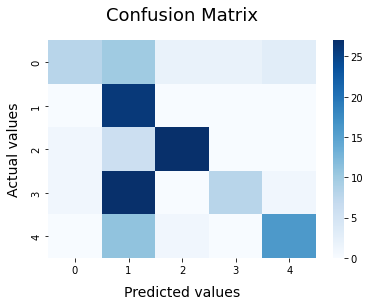

In [30]:
# using Bernoulli's Naive Bayes
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

           A       0.64      0.84      0.72        25
           B       0.83      0.96      0.89        26
           C       1.00      0.79      0.89        34
           D       0.84      0.70      0.76        37
           E       0.72      0.75      0.74        28

    accuracy                           0.80       150
   macro avg       0.81      0.81      0.80       150
weighted avg       0.82      0.80      0.80       150



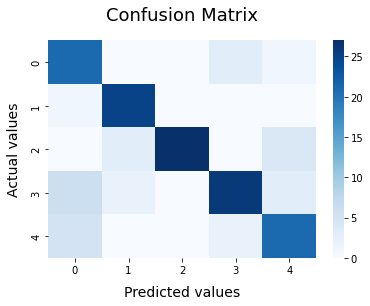

In [31]:
# using Support vector Machine
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           A       0.66      0.76      0.70        25
           B       0.83      0.92      0.87        26
           C       1.00      0.82      0.90        34
           D       0.81      0.78      0.79        37
           E       0.79      0.79      0.79        28

    accuracy                           0.81       150
   macro avg       0.81      0.82      0.81       150
weighted avg       0.82      0.81      0.82       150



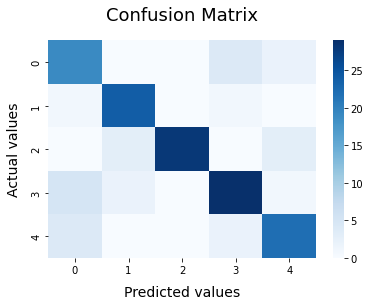

In [32]:
# using Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [33]:
final_model = LRmodel

In [34]:
'''
title = "laptop"
Description = "LAPTOP not working properly"

col_names = ["Description", "title"]
raw_data = pd.DataFrame([[Description, title]])
raw_data.columns = col_names
raw_data
'''
col_names = ["Description", "title"]

*DEPLOYING MODEL*

In [36]:
app = Flask(__name__)
@app.route("/")
def hello():
    return render_template("index.html")
@app.route("/sub", methods = ['POST'])
def submit():
    if request.method == "POST":
        title = request.form["title"]
        Description = request.form["body"]
        raw_data = pd.DataFrame([[Description, title]])
        raw_data.columns = col_names
        print(raw_data)
        raw_data = process_data(raw_data)
        X = raw_data.Description.astype(str)
        X = vectoriser.transform(X)
        y = final_model.predict(X)
        predicted_category = y
    return render_template("submit.html", show = predicted_category)
if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [11/Apr/2022 22:41:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 22:41:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 22:41:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 22:41:44] "POST /sub HTTP/1.1" 200 -


            Description   title
0  forgot wifi password  hello 


127.0.0.1 - - [11/Apr/2022 22:41:58] "POST /sub HTTP/1.1" 200 -


                   Description   title
0  can't see attendance in SAP  hello 


127.0.0.1 - - [11/Apr/2022 22:42:09] "POST /sub HTTP/1.1" 200 -


       Description   title
0  need admit card  hello 


127.0.0.1 - - [11/Apr/2022 22:42:23] "POST /sub HTTP/1.1" 200 -


    Description   title
0  laptop issue  hello 
